**Wael Dgheim**

github link: https://github.com/wmd06/EECE490_Hackathon.git

After examining the data, I realized that it is possible to infer a person's smoking type based on their sociodemographic situation, personality traits, and lifestyle factors. To achieve this, I preprocessed the dataset by cleaning and engineering features, such as mapping categorical variables to numerical formats.

I then utilized machine learning models, including a Neural Network and a Random Forest classifier, to predict the smoking type of individuals. These models were combined using a Stacking Classifier to leverage the strengths of both algorithms.

In [186]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, StackingClassifier

In [187]:
# Load the dataset
data = pd.read_excel('2024_PersonalityTraits_SurveyData.xls')

# Step 1: Remove the unnamed column, Last Page columns, and the columns with '[Comment]'
columns_to_drop = [col for col in data.columns if '[Comment]' in col]
columns_to_drop.append('Last page')
data_cleaned = data.drop(columns=columns_to_drop + [data.columns[0]])

# Fill remaining missing values (numerical: median, categorical: mode)
for col in data_cleaned.columns:
    if data_cleaned[col].dtype == 'object':  # Categorical
        data_cleaned[col].fillna(data_cleaned[col].mode()[0], inplace=True)
    else:  # Numerical
        data_cleaned[col].fillna(data_cleaned[col].median(), inplace=True)

# Mapping
map1= {
    "Agree strongly": 3, "Agree moderately": 2, "Agree a little": 1,
    "Neither agree nor disagree": 0, "Disagree a little": -1,
    "Disagree moderately": -2,"Disagree strongly": -3
  }

data_cleaned.replace(map1, inplace=True)

map2= {
    "Yes": 1, "No":0
    }
data_cleaned.replace(map2, inplace=True)

#To avoid the user having tried the cigarette at an age greater than his age
data_cleaned["How old were you the first time you smoked a full cigarette (not just a few puffs)?"] = data_cleaned[
    ["How old were you the first time you smoked a full cigarette (not just a few puffs)?", "How old are you?"]
].min(axis=1)

# Identify numerical columns
numerical_cols = data_cleaned.select_dtypes(include=['float64', 'int64']).columns

<ipython-input-187-175818a8303f>:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_cleaned[col].fillna(data_cleaned[col].mode()[0], inplace=True)
<ipython-input-187-175818a8303f>:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, i

<Figure size 1200x800 with 0 Axes>

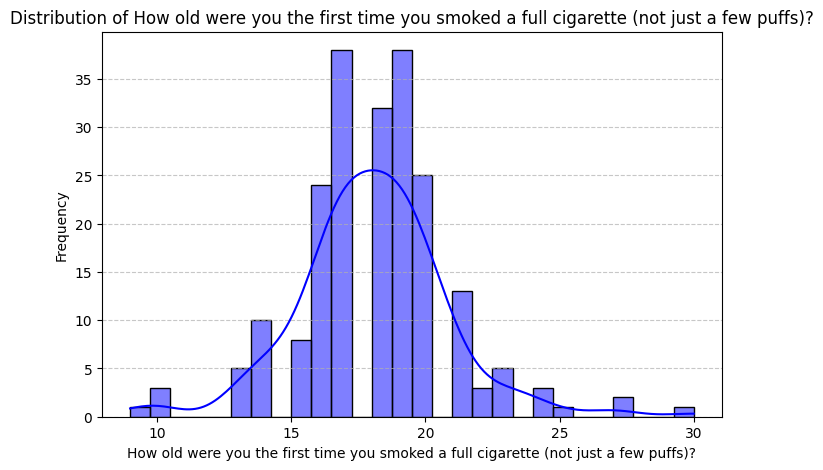

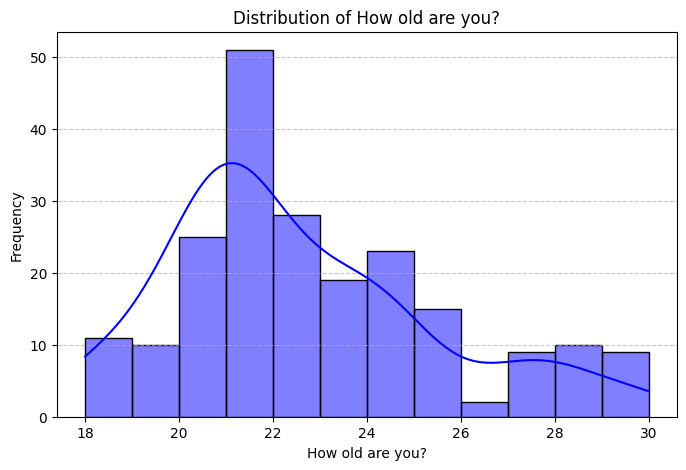

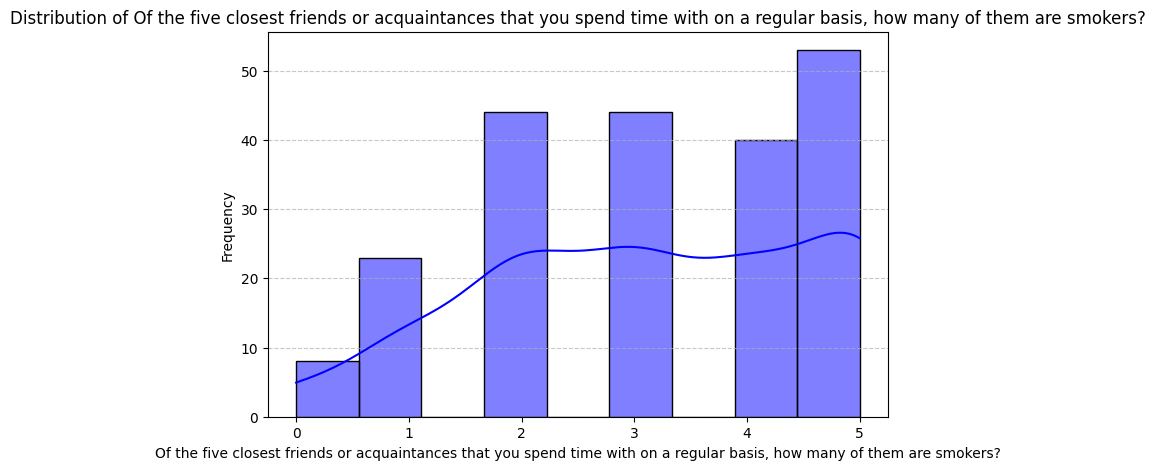

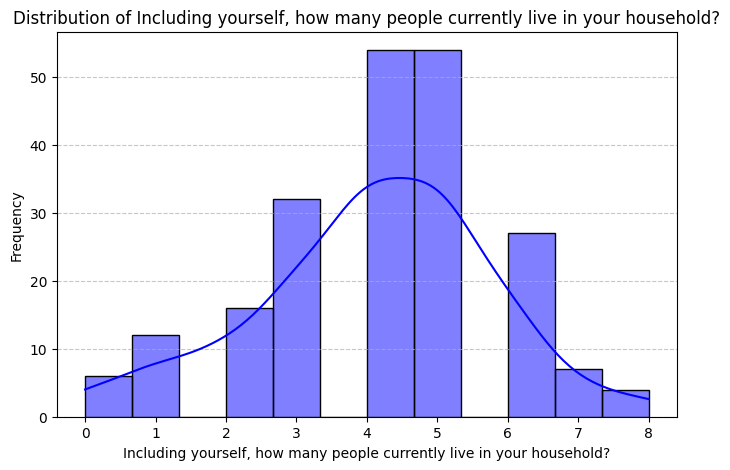

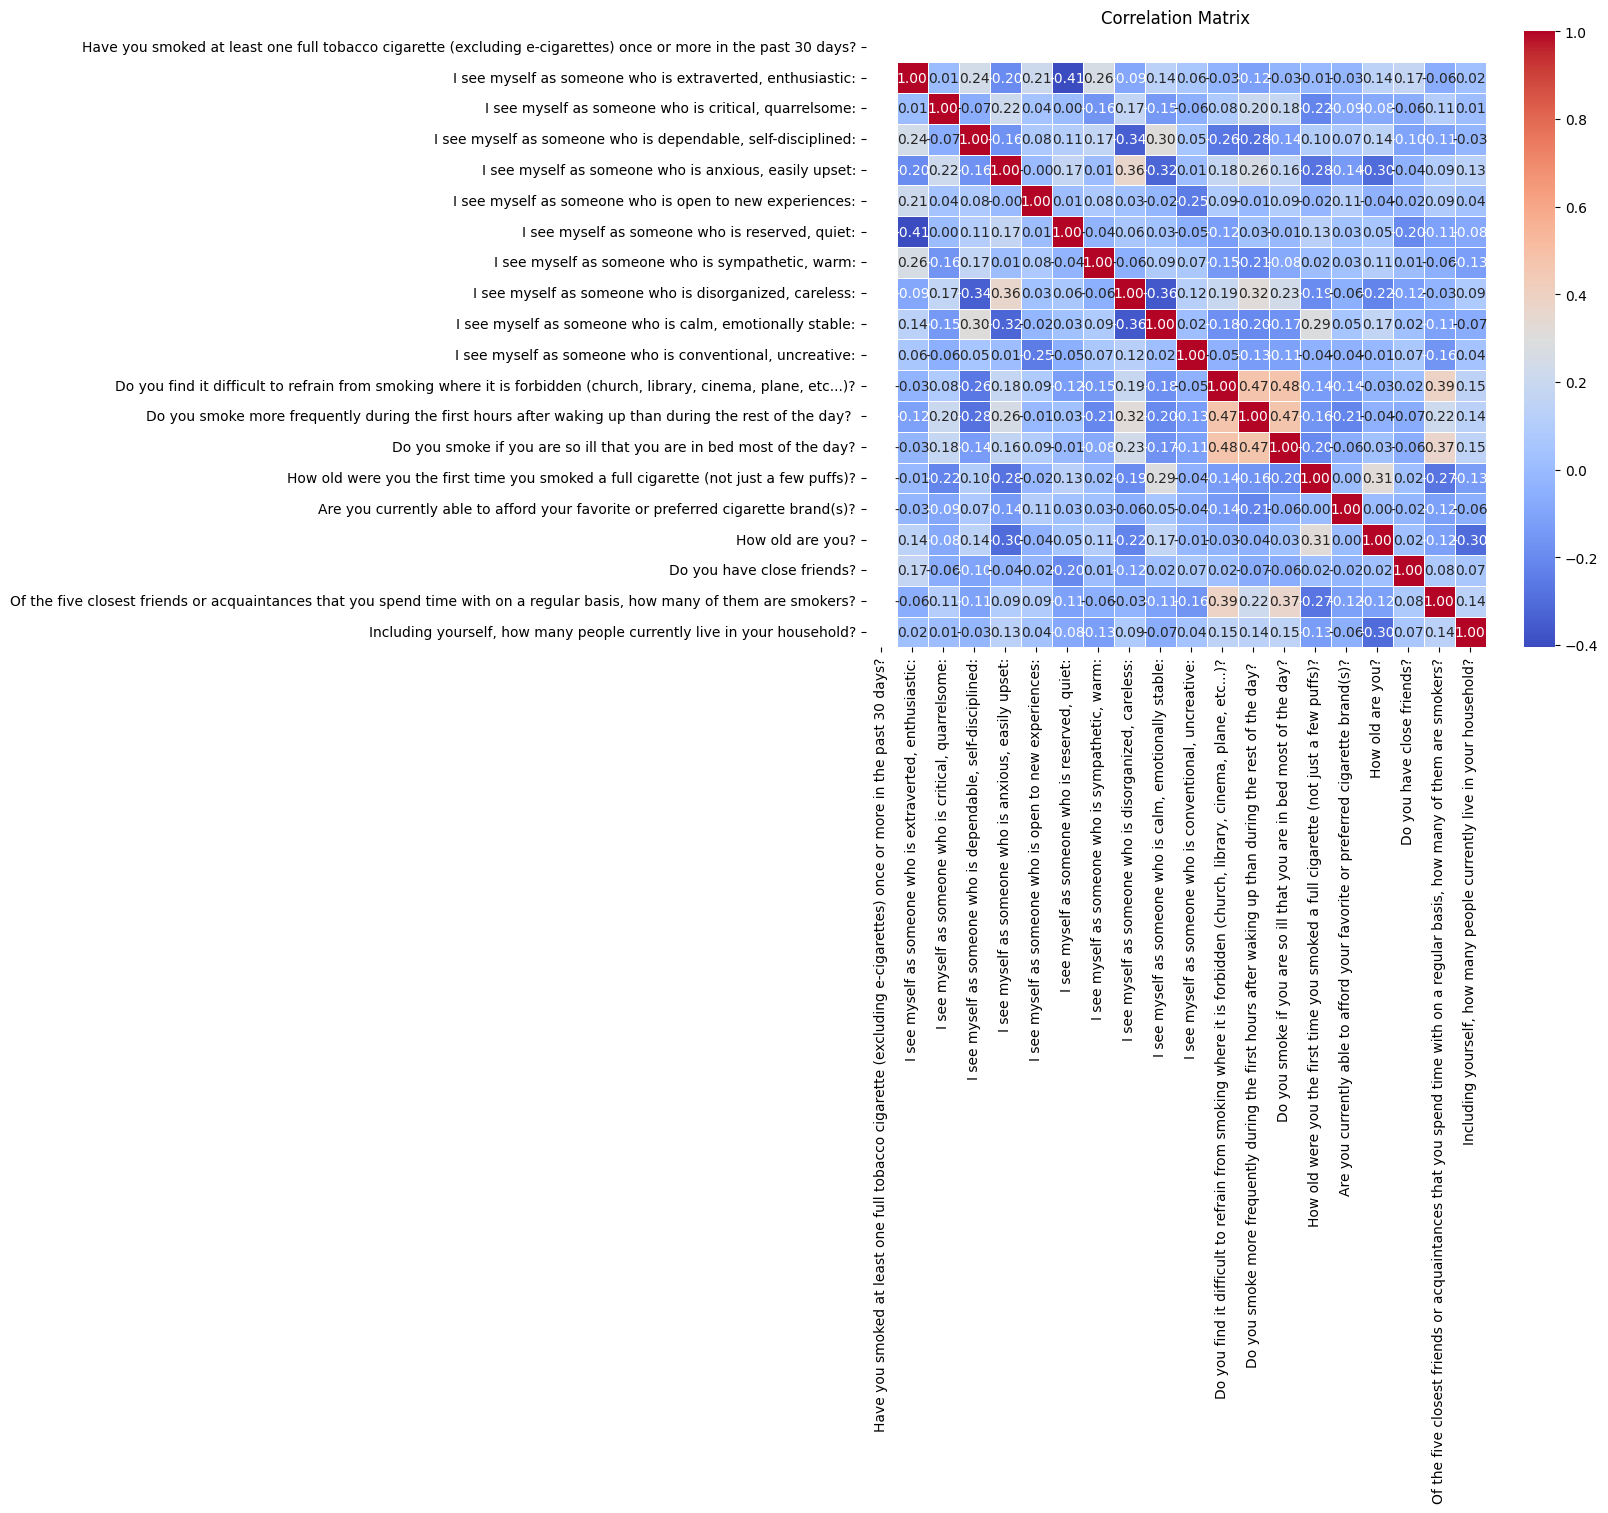

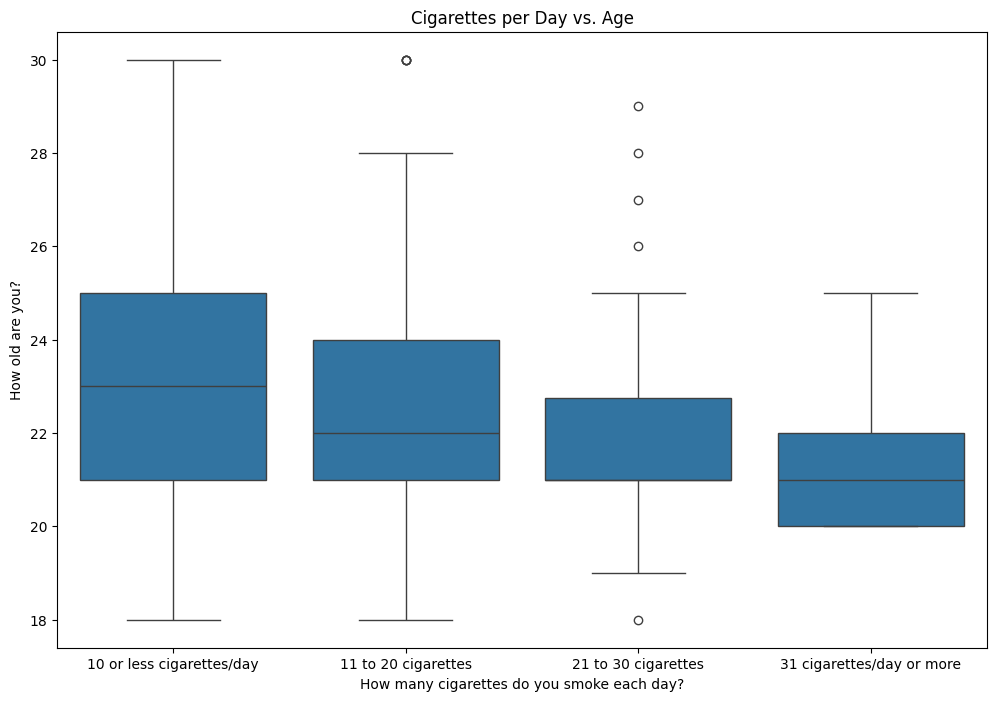

In [188]:
# Visualize some distributions
plt.figure(figsize=(12, 8))

numerical_cols_to_plot = ['How old were you the first time you smoked a full cigarette (not just a few puffs)?',
                          'How old are you?',
                          'Of the five closest friends or acquaintances that you spend time with on a regular basis, how many of them are smokers?',
                          'Including yourself, how many people currently live in your household?']

for col in numerical_cols_to_plot:
    plt.figure(figsize=(8, 5))
    sns.histplot(data_cleaned[col], kde=True, color="blue")
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

correlation_matrix = data_cleaned[numerical_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# Relationship between 'How many cigarettes do you smoke each day?' and 'Age'
plt.figure(figsize=(12, 8))
sns.boxplot(x='How many cigarettes do you smoke each day?', y='How old are you?', data=data_cleaned)
plt.title('Cigarettes per Day vs. Age')
plt.show()

In [191]:
# Define features and target variable
features = [
    'I see myself as someone who is extraverted, enthusiastic:',
    'I see myself as someone who is critical, quarrelsome:',
    'I see myself as someone who is dependable, self-disciplined:',
    'I see myself as someone who is anxious, easily upset:',
    'I see myself as someone who is open to new experiences:',
    'I see myself as someone who is reserved, quiet:',
    'I see myself as someone who is sympathetic, warm:',
    'I see myself as someone who is disorganized, careless:',
    'I see myself as someone who is calm, emotionally stable:',
    'I see myself as someone who is conventional, uncreative:',
    'How old are you?',
    'How old were you the first time you smoked a full cigarette (not just a few puffs)?',
    'Do you have close friends?',
    'Of the five closest friends or acquaintances that you spend time with on a regular basis, how many of them are smokers?',
    'How often do you exercise?',
    'On average, how many hours per day do you spend on social media for entertainment and social interaction (Facebook, Instagram, YouTube, etc...)?',
    'How often do you feel stressed?',
    'What is your current marital status?',
    'What is your current employment status?',
    'Including yourself, how many people currently live in your household?',
    'How would you describe your current income sufficiency?',
    'Sector',
    'Gender:',
    'What is the highest level of education you have attained?',
    'What is your main source of income?',
    'Do you find it difficult to refrain from smoking where it is forbidden (church, library, cinema, plane, etc...)?',
    'Do you smoke more frequently during the first hours after waking up than during the rest of the day? ',
    'Do you smoke if you are so ill that you are in bed most of the day?',
    'How soon after you wake up do you smoke your first cigarette?',
    "How would you describe your current smoking behavior compared to your smoking behavior before Lebanon's economic crisis and revolution began in 2019?",
    'If you receive payment in Lebanese Lira, what is your current estimated monthly household income? (If income is in US Dollars, then refer to the current black market exchange).',
    'To what extent were you financially (negatively) affected by the deterioration of the Lebanese economy?',
    'Employment Status'
]

X = data_cleaned[features]
y = data_cleaned['How many cigarettes do you smoke each day?']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

categorical_cols = ['Sector', 'Gender:', 'What is your current employment status?',
                    'What is the highest level of education you have attained?',
                    'What is your main source of income?', 'Do you have close friends?',
                    'How often do you exercise?',
                    'On average, how many hours per day do you spend on social media for entertainment and social interaction (Facebook, Instagram, YouTube, etc...)?',
                    'How often do you feel stressed?',
                    'How would you describe your current income sufficiency?',
                    'How soon after you wake up do you smoke your first cigarette?',
                    "How would you describe your current smoking behavior compared to your smoking behavior before Lebanon's economic crisis and revolution began in 2019?",
                    'What is your current marital status?',
                    'If you receive payment in Lebanese Lira, what is your current estimated monthly household income? (If income is in US Dollars, then refer to the current black market exchange).',
                    'To what extent were you financially (negatively) affected by the deterioration of the Lebanese economy?', 'Employment Status']

numerical_cols = [col for col in features if col not in categorical_cols]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Define the neural network model
nn_model = MLPClassifier(hidden_layer_sizes=(500,300,100), max_iter=1000, random_state=42, solver='adam',
                         early_stopping=True,  # Add early stopping
                         validation_fraction=0.2,  # Use 20% of training data for validation
                         n_iter_no_change=10,  # Stop if no improvement for 10 iterations
                         alpha=0.01)

stacking_classifier = StackingClassifier(
        estimators=[
            ('nn', nn_model),
            ('rf', RandomForestClassifier(n_estimators=300, random_state=42))
        ],
        final_estimator=LogisticRegression(),
        cv=5
    )

# Build the pipeline with the neural network and preprocessor
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', stacking_classifier)
])

# Fit the model
pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report:
                            precision    recall  f1-score   support

10 or less cigarettes/day       0.67      0.88      0.76        16
      11 to 20 cigarettes       0.57      0.67      0.62        12
      21 to 30 cigarettes       0.86      0.55      0.67        11
31 cigarettes/day or more       1.00      0.25      0.40         4

                 accuracy                           0.67        43
                macro avg       0.77      0.58      0.61        43
             weighted avg       0.72      0.67      0.66        43

Confusion Matrix:
 [[14  2  0  0]
 [ 4  8  0  0]
 [ 3  2  6  0]
 [ 0  2  1  1]]


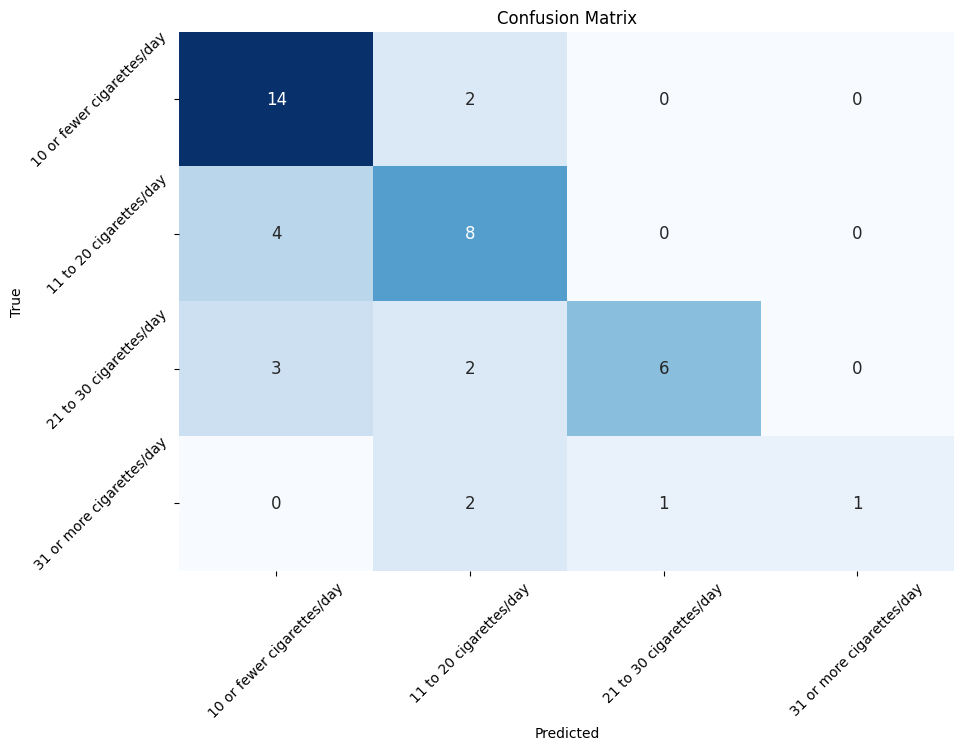

In [184]:
# Plot confusion matrix for multiclass classification
cm = confusion_matrix(y_test, y_pred)

class_labels = ['10 or fewer cigarettes/day', '11 to 20 cigarettes/day',
                '21 to 30 cigarettes/day', '31 or more cigarettes/day']
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels,
            cbar=False, annot_kws={"size": 12})
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()


Text(0.5, 1.0, 'True vs Predicted Cigarettes per Day')

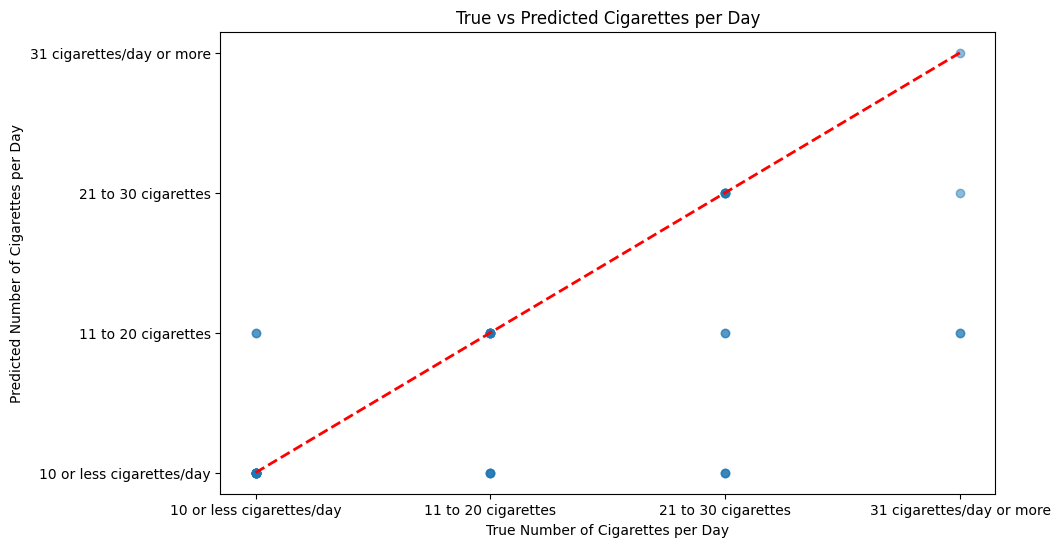

In [185]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('True Number of Cigarettes per Day')
plt.ylabel('Predicted Number of Cigarettes per Day')
plt.title('True vs Predicted Cigarettes per Day')